# MNIST master

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

Before doing this homework, read some code examples written in tensorflow. There is a good repository with code examples: https://github.com/aymericdamien/TensorFlow-Examples. As we already know, we need many samples to learn :)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import tensorflow as tf

In [7]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


In [8]:
X_train.shape

(50000, 1, 28, 28)

4

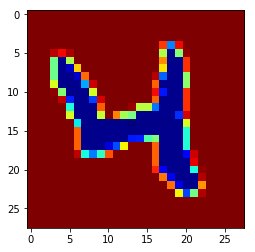

In [9]:
plt.imshow(-X_train[20, 0], cmap="jet")
y_train[20]

In [10]:
#defining placeholders for input and target
input_X = tf.placeholder(tf.float32, shape=[None, 1, 28, 28], 
                         name="X")
target_y = tf.placeholder(tf.int32, shape=[None], 
                          name="target_Y_integer")

Defining network architecture

In [11]:
mode=True
# flatten images to (batch_size x 728) matrix
input_X_reshaped = tf.reshape(input_X, shape=[-1, 1*28*28], 
                              name="reshape_X")


h1 = tf.layers.conv2d(tf.reshape(input_X, shape=[-1,28,28,1]), filters=32, kernel_size=[5,5], 
                     padding="same", activation=tf.nn.relu)
print(np.shape(h1))

h2 = tf.layers.max_pooling2d(h1, pool_size=2, strides=2)

print(np.shape(h2))


h3 = tf.layers.conv2d(h2, filters=64, kernel_size = [5,5],
                     padding='same', activation=tf.nn.relu)
print(np.shape(h3))

h4 = tf.layers.max_pooling2d(h3, pool_size=2, strides=2)

print(np.shape(h4))

h5 = tf.layers.dense(tf.reshape(h4, shape=[-1,3136]), units=1024, activation=None)

h6 = tf.layers.dropout(h5, rate=0.4, training=mode)

h7 = tf.nn.relu(h6)

# 10 neurons (1 for each digit).
# This predicts scores for the classes
l2 = tf.layers.dense(h7, units=10, activation=None)


# We use softmax nonlinearity to make probabilities add up to 1
l_out = tf.nn.softmax(l2)

# Prediction
y_predicted = tf.argmax(l2, axis=-1)

W0725 20:23:15.447592 140157600978752 deprecation.py:323] From <ipython-input-11-a5078e2faa23>:8: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0725 20:23:15.450428 140157600978752 deprecation.py:506] From /home/yeva/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0725 20:23:15.627611 140157600978752 deprecation.py:323] From <ipython-input-11-a5078e2faa23>:11: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0725 20:23:15.743550 140157600978752 deprecatio

(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 14, 14, 64)
(?, 7, 7, 64)


W0725 20:23:15.970976 140157600978752 deprecation.py:323] From <ipython-input-11-a5078e2faa23>:26: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


In [12]:
weights = tf.trainable_variables()
weights

[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(3136, 1024) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>]

### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Tensorflow builtins

In [13]:
# Mean categorical crossentropy as a loss function
# - similar to logistic loss but for multiclass targets
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=target_y, logits=l2, name="softmax_loss"))

In [14]:
accuracy, update_accuracy = tf.metrics.accuracy(target_y, y_predicted)
tf.local_variables()

[<tf.Variable 'accuracy/total:0' shape=() dtype=float32_ref>,
 <tf.Variable 'accuracy/count:0' shape=() dtype=float32_ref>]

In [15]:
optimzer = tf.train.GradientDescentOptimizer(learning_rate=0.09)
train_step = optimzer.minimize(loss)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [16]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# Training loop

Model saver.
<br>
See more:
http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

In [ ]:
model_path = "./checkpoints/model.ckpt"
saver = tf.train.Saver(max_to_keep=3)

In [ ]:
import time

num_epochs = 100 # amount of passes through the data

batch_size = 50 # number of samples processed at each function call

with tf.Session() as sess:
    # initialize global wariables
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()

        sess.run(tf.local_variables_initializer())
        for batch in iterate_minibatches(X_train, y_train,batch_size):
            inputs, targets = batch

            _, train_err_batch, _ = sess.run(
                [train_step, loss, update_accuracy], 
                feed_dict={input_X: inputs, target_y:targets}
            )
            train_err += train_err_batch
            train_batches += 1
        train_acc = sess.run(accuracy)

        # And a full pass over the validation data:
        sess.run(tf.local_variables_initializer())
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            sess.run(update_accuracy, feed_dict={input_X: inputs, 
                                                 target_y:targets})
        val_acc = sess.run(accuracy)


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc * 100))
        
        # save model
        save_path = saver.save(sess, model_path, global_step=epoch)
        print("  Model saved in file: %s" % save_path)

Now we can restore saved parameters:

In [ ]:
mode=False
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    load_path = saver.restore(sess, saver.last_checkpoints[-1])
    print("Model restored from file: %s" % save_path)
    
    sess.run(tf.local_variables_initializer())
    for batch in iterate_minibatches(X_test, y_test, 500):
        inputs, targets = batch
        sess.run(update_accuracy, feed_dict={input_X: inputs, 
                                                   target_y:targets})
    test_acc = sess.run(accuracy)
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc* 100))

    if test_acc * 100 > 99.5:
        print ("Achievement unlocked: 80lvl Warlock!")
    else:
        print ("We need more magic!")

# Now improve it!

* Moar layers!
* Moar units!
* Different nonlinearities!